# Using BERT + BiLSTM as Sentiment Analyzer
## Unified preprocessed:
1. 字母小寫
2. 刪除網址
3. 移除標點符號（所有標點符號都要刪除）
4. 移除非英文字母
5. 計算類別權重（class_weight）
6. 移除停用詞（stop_words）
7. 不替換用戶名（replace_username：False）
8. 不替換 COVID 相關詞彙（replace_covid：False）

### 2025/05/27 1:49 by sky

## 步驟1：載入套件

In [18]:
pip install nlpaug

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd  # 用於資料讀取與處理
import numpy as np  # 用於數值運算
import torch  # PyTorch主套件
import torch.nn as nn  # PyTorch神經網路模組
import torch.optim as optim  # PyTorch優化器
from torch.utils.data import Dataset, DataLoader  # PyTorch資料集與資料加載器
from transformers import BertTokenizer, BertModel  # BERT 分詞與模型
import re  # 正則表達式，用於去除URL
import string  # 處理標點符號
from sklearn.utils.class_weight import compute_class_weight  # 計算類別權重
import matplotlib.pyplot as plt  # 用於視覺化
from tqdm import tqdm  # 進度條
from torch.optim.lr_scheduler import ReduceLROnPlateau  # 學習率調度器
from torch.optim.lr_scheduler import CosineAnnealingLR  # 學習率調度
import nltk  # 用於停用詞清理
from nltk.corpus import stopwords  # 停用詞列表
import matplotlib.font_manager as fm  # 用於字型設置
import nlpaug.augmenter.word as naw  # 數據增強
import logging  # 錯誤日誌
from sklearn.metrics import f1_score, roc_auc_score

# 下載停用詞列表
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# 設置日誌
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 設置中文字型以解決 Glyph missing 問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 使用微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 步驟2：設置參數

In [21]:
OUTPUT_DIM = 5  # 五種情感類別
HIDDEN_DIM = 128  # LSTM 隱藏層維度
NUM_LAYERS = 2  # LSTM 層數
DROPOUT = 0.4  # Dropout 比例（增強正則化）
BATCH_SIZE = 64  # 批次大小
EPOCHS = 15  # 訓練輪數
MAX_LEN = 60  # 最大序列長度（調整以減少 padding）
PATIENCE = 5  # 早停耐心值
CLIP_GRAD_NORM = 1.0  # 梯度裁剪範圍

In [22]:
# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 步驟3：資料清理函數

In [23]:
def clean_text(text):
    # 轉換為小寫
    text = text.lower()
    # 移除網址
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 移除標點符號
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 移除非英文字母
    text = re.sub(r'[^a-z\s]', '', text)
    # 自定義停用詞（保留情感相關詞彙）
    custom_stop_words = set(stopwords.words('english')) - {'not', 'very', 'really'}
    text = ' '.join(word for word in text.split() if word not in custom_stop_words)
    # 移除多餘空格
    text = ' '.join(text.split())
    return text

## 步驟4：讀取資料

In [24]:
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

# 清理資料
train_df['clean_text'] = train_df['OriginalTweet'].apply(clean_text)
test_df['clean_text'] = test_df['OriginalTweet'].apply(clean_text)

# 檢查清理後文本長度
text_lengths = train_df['clean_text'].apply(lambda x: len(x.split()))
print(f"平均長度: {text_lengths.mean():.2f}, 最大長度: {text_lengths.max()}")

print("清理後的訓練資料前5筆：")
print(train_df[['OriginalTweet', 'clean_text']].head())
print("\n清理後的測試資料前5筆：")
print(test_df[['OriginalTweet', 'clean_text']].head())

平均長度: 18.14, 最大長度: 40
清理後的訓練資料前5筆：
                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                          clean_text  
0                        menyrbie philgahan chrisitv  
1  advice talk neighbours family exchange phone n...  
2  coronavirus australia woolworths give elderly ...  
3  food stock not one empty please dont panic eno...  
4  ready go supermarket covid outbreak not im par...  

清理後的測試資料前5筆：
                                       OriginalTweet  \
0  TRENDING: New Yorkers encounter empty supermar...   
1  When I couldn't find hand sanitizer at Fred Me...   
2  Find out how you can protect yourself and love...   
3  #Panic buying hits #NewYork City as anxious sh...   
4  #

## 步驟5：標籤編碼 & class weight

In [25]:
sentiment_mapping = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}
train_df['label'] = train_df['Sentiment'].map(sentiment_mapping)
test_df['label'] = test_df['Sentiment'].map(sentiment_mapping)

print("\n訓練資料類別分佈：")
print(train_df['label'].value_counts())
print("\n測試資料類別分佈：")
print(test_df['label'].value_counts())

# 計算類別權重
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


訓練資料類別分佈：
label
3    11422
1     9917
2     7713
4     6624
0     5481
Name: count, dtype: int64

測試資料類別分佈：
label
1    1041
3     947
2     619
4     599
0     592
Name: count, dtype: int64


## 步驟 6：創建自定義資料集

In [26]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [27]:
# 初始化 BERT 分詞器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 創建資料集
train_dataset = TweetDataset(
    texts=train_df['clean_text'].to_numpy(),
    labels=train_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = TweetDataset(
    texts=test_df['clean_text'].to_numpy(),
    labels=test_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# 創建資料加載器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## 步驟7：定義 BERT-BiLSTM 模型

In [28]:
class BertBiLSTM(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(BertBiLSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.encoder.layer[:8].parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(hidden_dim * 4)  # 添加 Layer Normalization
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
    
    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = bert_outputs[0]
        lstm_out, _ = self.lstm(embedded)
        max_pool, _ = torch.max(lstm_out, dim=1)
        avg_pool = torch.mean(lstm_out, dim=1)
        pooled = torch.cat((max_pool, avg_pool), dim=1)
        pooled = self.ln(pooled)  # 應用 Layer Normalization
        pooled = self.dropout(pooled)
        output = self.fc(pooled)
        return output

## 步驟9：初始化模型、損失函數與優化器

In [29]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [37]:
# 原有程式碼
model = BertBiLSTM(
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_bert = optim.AdamW(model.bert.parameters(), lr=2e-5)
optimizer_rest = optim.AdamW([param for name, param in model.named_parameters() if 'bert' not in name], lr=5e-5)
scheduler_bert = ReduceLROnPlateau(optimizer_bert, mode='max', factor=0.5, patience=1)
scheduler_rest = CosineAnnealingLR(optimizer_rest, T_max=5)

# 插入修正後的 summary 程式碼
from torchinfo import summary
print("\n🎯 BiLSTM 模型結構：")
summary(model, 
        input_data={
            'input_ids': torch.zeros((BATCH_SIZE, MAX_LEN), dtype=torch.long).to(device),
            'attention_mask': torch.ones((BATCH_SIZE, MAX_LEN), dtype=torch.long).to(device)
        },
        device=device.type)


🎯 BiLSTM 模型結構：


Layer (type:depth-idx)                                       Output Shape              Param #
BertBiLSTM                                                   [64, 5]                   --
├─BertModel: 1-1                                             [64, 768]                 --
│    └─BertEmbeddings: 2-1                                   [64, 60, 768]             --
│    │    └─Embedding: 3-1                                   [64, 60, 768]             23,440,896
│    │    └─Embedding: 3-2                                   [64, 60, 768]             1,536
│    │    └─Embedding: 3-3                                   [1, 60, 768]              393,216
│    │    └─LayerNorm: 3-4                                   [64, 60, 768]             1,536
│    │    └─Dropout: 3-5                                     [64, 60, 768]             --
│    └─BertEncoder: 2-2                                      [64, 60, 768]             --
│    │    └─ModuleList: 3-6                                  --             

## 步驟9：訓練與驗證函數

In [13]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(data_loader, desc="訓練"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(data_loader), correct / total

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="驗證"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    return total_loss / len(data_loader), correct / total, f1, auc

## 步驟 10：訓練模型與 confusion matrix

In [14]:
best_val_f1 = -float('inf')
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_auc_scores = []

for epoch in range(1, EPOCHS + 1):
    print(f"輪次 {epoch}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, val_auc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_auc_scores.append(val_auc)

    print(f"訓練損失: {train_loss:.4f}, 訓練準確率: {train_acc:.4f}")
    print(f"驗證損失: {val_loss:.4f}, 驗證準確率: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    scheduler.step() # Cosine Annealing 學習率調度

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("早停觸發，停止訓練")
            break

# 載入最佳模型進行最終評估
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_f1, test_auc = evaluate(model, test_loader, criterion, device)
print(f"\n最終測試損失: {test_loss:.4f}, 最終測試準確率: {test_acc:.4f}, 最終F1: {test_f1:.4f}, 最終AUC: {test_auc:.4f}")

輪次 1/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.14it/s]


訓練損失: 1.1772, 訓練準確率: 0.4614
驗證損失: 1.0219, 驗證準確率: 0.5377, F1: 0.5221, AUC: 0.8522
輪次 2/15


驗證: 100%|██████████| 60/60 [00:10<00:00,  5.68it/s]


訓練損失: 0.8627, 訓練準確率: 0.6238
驗證損失: 0.8609, 驗證準確率: 0.6190, F1: 0.6083, AUC: 0.8949
輪次 3/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.13it/s]


訓練損失: 0.7159, 訓練準確率: 0.7013
驗證損失: 0.8128, 驗證準確率: 0.6569, F1: 0.6512, AUC: 0.9112
輪次 4/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.14it/s]


訓練損失: 0.6166, 訓練準確率: 0.7494
驗證損失: 0.7142, 驗證準確率: 0.7085, F1: 0.7064, AUC: 0.9246
輪次 5/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.12it/s]


訓練損失: 0.5464, 訓練準確率: 0.7825
驗證損失: 0.7369, 驗證準確率: 0.6914, F1: 0.6895, AUC: 0.9227
輪次 6/15


驗證: 100%|██████████| 60/60 [00:10<00:00,  5.81it/s]


訓練損失: 0.4949, 訓練準確率: 0.8044
驗證損失: 0.6952, 驗證準確率: 0.7241, F1: 0.7219, AUC: 0.9321
輪次 7/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.02it/s]


訓練損失: 0.4500, 訓練準確率: 0.8272
驗證損失: 0.7248, 驗證準確率: 0.7262, F1: 0.7246, AUC: 0.9301
輪次 8/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.02it/s]


訓練損失: 0.4234, 訓練準確率: 0.8340
驗證損失: 0.7178, 驗證準確率: 0.7299, F1: 0.7288, AUC: 0.9332
輪次 9/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.13it/s]


訓練損失: 0.4008, 訓練準確率: 0.8468
驗證損失: 0.7254, 驗證準確率: 0.7285, F1: 0.7278, AUC: 0.9321
輪次 10/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.09it/s]


訓練損失: 0.3894, 訓練準確率: 0.8510
驗證損失: 0.7246, 驗證準確率: 0.7285, F1: 0.7269, AUC: 0.9324
輪次 11/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.21it/s]


訓練損失: 0.3860, 訓練準確率: 0.8506
驗證損失: 0.7246, 驗證準確率: 0.7285, F1: 0.7269, AUC: 0.9324
輪次 12/15


驗證: 100%|██████████| 60/60 [00:10<00:00,  5.90it/s]


訓練損失: 0.3877, 訓練準確率: 0.8522
驗證損失: 0.7240, 驗證準確率: 0.7296, F1: 0.7283, AUC: 0.9322
輪次 13/15


驗證: 100%|██████████| 60/60 [00:10<00:00,  5.66it/s]


訓練損失: 0.3914, 訓練準確率: 0.8493
驗證損失: 0.7190, 驗證準確率: 0.7343, F1: 0.7333, AUC: 0.9329
輪次 14/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.60it/s]


訓練損失: 0.3879, 訓練準確率: 0.8493
驗證損失: 0.7425, 驗證準確率: 0.7341, F1: 0.7338, AUC: 0.9325
輪次 15/15


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.52it/s]


訓練損失: 0.3846, 訓練準確率: 0.8510
驗證損失: 0.7408, 驗證準確率: 0.7235, F1: 0.7221, AUC: 0.9295


驗證: 100%|██████████| 60/60 [00:09<00:00,  6.46it/s]


最終測試損失: 0.7425, 最終測試準確率: 0.7341, 最終F1: 0.7338, 最終AUC: 0.9325


## 步驟11：視覺化訓練過程

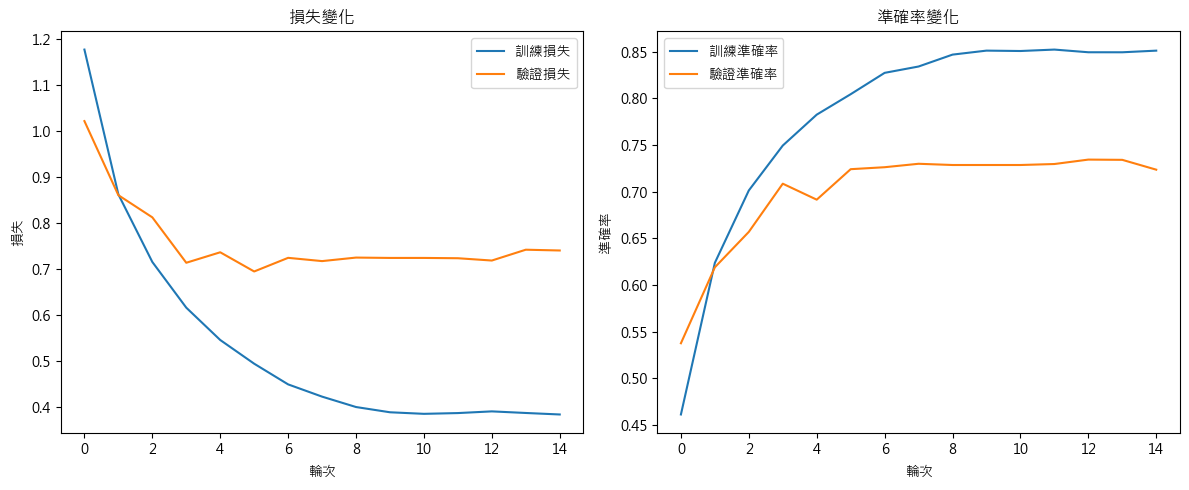

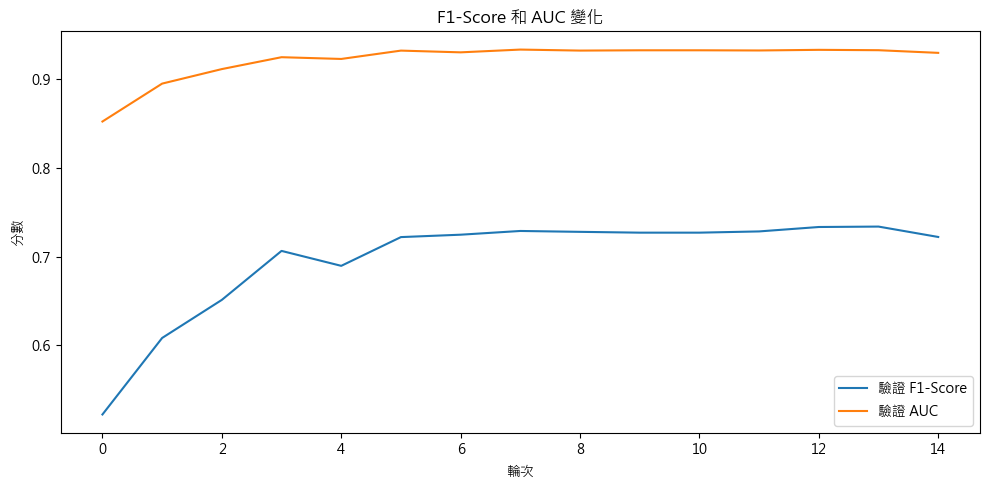

In [15]:
# 繪製訓練過程圖表
plt.figure(figsize=(12, 5))

# 損失圖
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='訓練損失')
plt.plot(val_losses, label='驗證損失')
plt.title('損失變化')
plt.xlabel('輪次')
plt.ylabel('損失')
plt.legend()

# 準確率圖
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='訓練準確率')
plt.plot(val_accuracies, label='驗證準確率')
plt.title('準確率變化')
plt.xlabel('輪次')
plt.ylabel('準確率')
plt.legend()

plt.tight_layout()
plt.show()

# F1 和 AUC 圖表
plt.figure(figsize=(10, 5))
plt.plot(val_f1_scores, label='驗證 F1-Score')
plt.plot(val_auc_scores, label='驗證 AUC')
plt.title('F1-Score 和 AUC 變化')
plt.xlabel('輪次')
plt.ylabel('分數')
plt.legend()
plt.tight_layout()
plt.show()

生成混淆矩陣資料: 100%|██████████| 60/60 [00:09<00:00,  6.53it/s]


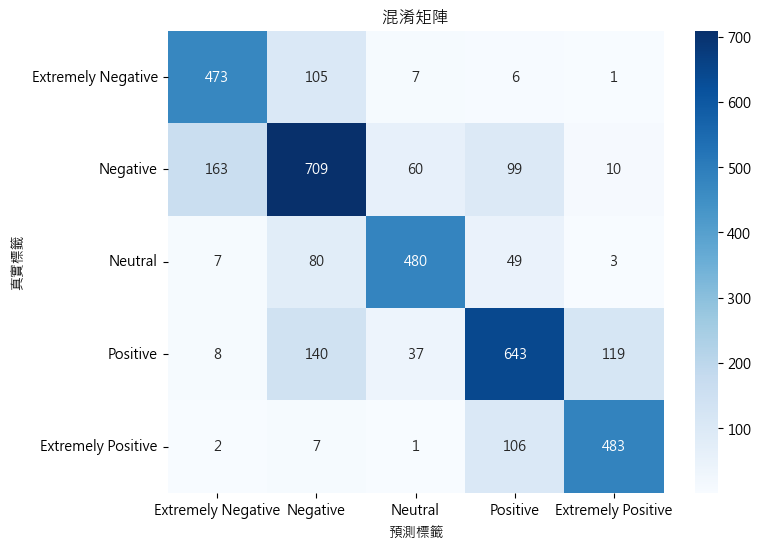

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data_loader, device, sentiment_mapping):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="生成混淆矩陣資料"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    
    # 根據 sentiment_mapping 的值來排序類別名稱，確保矩陣順序正確
    sorted_labels = sorted(sentiment_mapping, key=sentiment_mapping.get)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted_labels, yticklabels=sorted_labels)
    plt.xlabel('預測標籤')
    plt.ylabel('真實標籤')
    plt.title('混淆矩陣')
    plt.show()

# 調用函數繪製混淆矩陣
plot_confusion_matrix(model, test_loader, device, sentiment_mapping)